# 決定木 分類

## 【問題1】ジニ不純度を求める関数

In [833]:
import numpy as np
import math
from sklearn.metrics import accuracy_score
import copy 
import time
import matplotlib.pyplot as plt
%matplotlib inline

class ScratchDecesionTreeClassifier():
    """
    決定木分類のスクラッチ実装

    Parameters
    ----------
   　max_depth : int
      最大のツリーの深さ
    
    Attributes
    ----------
    self.n : int
      Xのカラム数（特徴量の数）
    self.left : インスタンス
    　　左下のノード
    self.right : インスタンス
    　　右下のノード
    self.depth : int
      このインススタンスのツリーにおける深さ
    self.leaf : int
      リーフのクラス
    self.feature : int
      このノードの分割条件の特徴量のカラム
    self.threshold : float
      このノードの分割条件の閾値
    self.score : float
      このノードの分割条件の情報利得
    self.left : 次の形のndarray, shape (n_features,1)
      パラメータ
    """

    def __init__(self, max_depth=1):
        self.n = None
        self.left  = None
        self.right = None
        self.max_depth = max_depth
        self.depth = None
        self.leaf = None
        self.feature = None
        self.threshold = None
        self.score = 0
        
    def fit(self, X, y):
        
        t0 = time.time() #時間の測定
        y = y.reshape(len(y), 1) #リシェイプ
        Xy = np.hstack((X,y)) #Xy合成
        
        self._split_tree(Xy, depth=0) #学習の開始
        
        #時間の表示
        t1 = time.time()
        print('time : {}s'.format(t1-t0))
        
    def _split_tree(self, Xy, depth):
        #再帰呼び出しでツリーを作成していく関数。
        
        self.depth = depth
        self.n = Xy.shape[1] - 1
        print("Recursion depth: " + str(self.depth)) #現在のdepthを表示
        
        #深さが設定まできたら、もしくはジニ不順度が０になったら分割を終了する
        if (self.depth == self.max_depth) or (self._gini_Impurity(Xy[:, -1]) == 0):
            self._leaf(Xy[:, -1]) #リーフの処理
            return
        #分割条件の設定
        self._maximum_information_gain(Xy) 
        print("Recursion score: {}" .format(self.score))
        #ジニ不順度が下がらないようなら分割終了
        if self.score == 0:
            self._leaf(Xy[:, -1]) #リーフの処理
            return
        #条件の通りデータを分割する
        left_Xy = Xy[np.where(Xy[:, self.feature] >= self.threshold), :][0] #np.whereでaxisが一つ増えているので[0]
        right_Xy = Xy[np.where(Xy[:, self.feature] < self.threshold), :][0]
        #分割ノードのインスタンスを作成
        self.left  = ScratchDecesionTreeClassifier(self.max_depth)
        self.right = ScratchDecesionTreeClassifier(self.max_depth)
    
        self.left._split_tree(left_Xy, depth + 1)   # 再帰呼び出し
        self.right._split_tree(right_Xy, depth + 1)  # 再帰呼び出し
    
    def predict(self, X):
        #予測したnp.arrayを返す
        return np.array([self._predict_loop(X[i, :]) for i in range(len(X))])
        
    def _predict_loop(self, x):
         #再帰呼び出しでツリーを降っていきクラスを予測する関数　
        #x: ndarray  shape(1, fetures)  １つだけのサンプルデータ
            
        #まずはリーフか判定 （xは１サンプルデータ）
        if not self.leaf == None:
            return self.leaf
        
        #閾値以上ならノードを移動、リーフが見つかるまで繰り返す
        if x[self.feature] >= self.threshold:
            return self.left._predict_loop(x) #再帰呼び出し
        else:
            return self.right._predict_loop(x) #再帰呼び出し
            
    def _leaf(self, y):
        #leafに一番多いクラスを格納する
        
        label, count = np.unique(y, return_counts=True)
        self.leaf = label[np.argmax(count)]
        
    def _maximum_information_gain(self,Xy):
        #情報利得を全特徴量と閾値で計算し、一番情報利得が高い分割条件をインスタンス変数へ
        
        y = Xy[:,-1]
        #特徴量の数でループ
        for i in range(self.n):
            uni_X = np.unique(Xy[:, i]) #閾値をユニークで取得
            uni_X = np.delete(uni_X, np.where(uni_X == uni_X.min())) #最小の閾値はいらないので消す
            #閾値の数でループ
            for threshold in uni_X:
                left_ind = np.where(Xy[:, i] >= threshold)[0] #閾値以上のindex抜き出す
                right_ind = np.where(Xy[:, i] < threshold)[0] #閾値以下のindex抜き出す
                IG = self._Information_gain(y, left_ind, right_ind) #情報利得の計算
                #一番高い情報利得を残す
                if self.score < IG:
                    self.score = IG
                    self.threshold = threshold
                    self.feature =  i
    
    def _gini_Impurity(self, y):
        #入力されたyでジニ不純度を計算
        
        K = np.unique(y) #クラスの数
        ntall = len(y) #総サンプル数
        nti = np.array([sum(y == i) for i in K])
        return 1 - sum((nti / ntall)**2)
    
    def _Information_gain(self, y, left_ind, right_ind):
        #情報利得を計算
        
        npall = len(y) #親ノードのサンプル数
        nlall = len(left_ind) #左のサンプル数
        nrall = len(right_ind) #右のサンプル数
        return self._gini_Impurity(y) -  nlall / npall * self._gini_Impurity(y[left_ind]) - nrall / npall * self._gini_Impurity(y[right_ind])
        
    def accuracy(self, y_test, y_pred):
        #accuracyを計算して返す
        return accuracy_score(y_test, y_pred)
    
    def plot_decision_area(self, X, y) :
        #決定領域をプロットします。
        
        X_label1 = X[y==0, :]
        X_label2 = X[y==1, :]

        plt.scatter(X_label1[:, 0], X_label1[:, 1],  c="red", edgecolor="red", label="0")
        plt.scatter(X_label2[:, 0], X_label2[:, 1],  c="blue", edgecolor="blue", label="1")

        #メッシュデータを作成
        x1_min, x1_max = X[:, 0].min()-1, X[:, 0].max()+1
        x2_min, x2_max = X[:, 1].min()-1, X[:, 1].max()+1
        x1_mesh, x2_mesh = np.meshgrid(np.arange(x1_min, x1_max, 0.01),
                                           np.arange(x2_min, x2_max, 0.01))

        #メッシュデータ全部を学習モデルで分類
        z = self.predict(np.array([x1_mesh.ravel(), x2_mesh.ravel()]).T)
        z = z.reshape(x1_mesh.shape)
        # メッシュデータと分離クラスを使って決定境界を描いている
        plt.contourf(x1_mesh, x2_mesh, z, alpha=0.4, cmap="gnuplot")
        plt.xlim(x1_mesh.min(), x1_mesh.max())
        plt.ylim(x2_mesh.min(), x2_mesh.max())

        plt.xlabel("X1")
        plt.ylabel("X2")
        plt.title("Determining region")
        plt.legend()
    
    def plot_decision_area_3class(self, X, y) :
        #決定領域をプロットします。3クラス版
        
        X_label1 = X[y==0, :]
        X_label2 = X[y==1, :]
        X_label3 = X[y==2, :]

        plt.scatter(X_label1[:, 0], X_label1[:, 1],  c="red", edgecolor="red", label="0")
        plt.scatter(X_label2[:, 0], X_label2[:, 1],  c="blue", edgecolor="blue", label="1")
        plt.scatter(X_label3[:, 0], X_label3[:, 1],  c="green", edgecolor="green", label="2")

        #メッシュデータを作成
        x1_min, x1_max = X[:, 0].min()-1, X[:, 0].max()+1
        x2_min, x2_max = X[:, 1].min()-1, X[:, 1].max()+1
        x1_mesh, x2_mesh = np.meshgrid(np.arange(x1_min, x1_max, 0.01),
                                           np.arange(x2_min, x2_max, 0.01))

        #メッシュデータ全部を学習モデルで分類
        z = self.predict(np.array([x1_mesh.ravel(), x2_mesh.ravel()]).T)
        z = z.reshape(x1_mesh.shape)
        # メッシュデータと分離クラスを使って決定境界を描いている
        plt.contourf(x1_mesh, x2_mesh, z, alpha=0.4, colors=['red', 'blue', 'green', 'pink', 'yellow'])
        plt.xlim(x1_mesh.min(), x1_mesh.max())
        plt.ylim(x2_mesh.min(), x2_mesh.max())

        plt.xlabel("X1")
        plt.ylabel("X2")
        plt.title("Determining region")
        plt.legend()

In [826]:
#アイリスデータの取り込み
from sklearn.datasets import load_iris
import pandas as pd
from sklearn.model_selection import train_test_split
iris = load_iris()
X = pd.DataFrame(iris.data, columns=iris.feature_names) #Dataframe ”X”を作成
#columns = ["petal length (cm)", "petal width (cm)"]
columns = ['sepal length (cm)', 'petal length (cm)']
X = X[columns]
X["TARGET"] = iris.target
#X = X[X["TARGET"] > 0]
y = X["TARGET"].values
#y[y==2] = 0
X = X.drop("TARGET", axis = 1).values

from sklearn.preprocessing import StandardScaler
sc = StandardScaler()
sc.fit(X)
X = sc.transform(X)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=40)

In [784]:
#シンプルデータセット２
X = np.array([[-0.44699 , -2.8073  ],[-1.4621  , -2.4586  ],
       [ 0.10645 ,  1.9242  ],[-3.5944  , -4.0112  ],
       [-0.9888  ,  4.5718  ],[-3.1625  , -3.9606  ],
       [ 0.56421 ,  0.72888 ],[-0.60216 ,  8.4636  ],
       [-0.61251 , -0.75345 ],[-0.73535 , -2.2718  ],
       [-0.80647 , -2.2135  ],[ 0.86291 ,  2.3946  ],
       [-3.1108  ,  0.15394 ],[-2.9362  ,  2.5462  ],
       [-0.57242 , -2.9915  ],[ 1.4771  ,  3.4896  ],
       [ 0.58619 ,  0.37158 ],[ 0.6017  ,  4.3439  ],
       [-2.1086  ,  8.3428  ],[-4.1013  , -4.353   ],
       [-1.9948  , -1.3927  ],[ 0.35084 , -0.031994],
       [ 0.96765 ,  7.8929  ],[-1.281   , 15.6824  ],
       [ 0.96765 , 10.083   ],[ 1.3763  ,  1.3347  ],
       [-2.234   , -2.5323  ],[-2.9452  , -1.8219  ],
       [ 0.14654 , -0.28733 ],[ 0.5461  ,  5.8245  ],
       [-0.65259 ,  9.3444  ],[ 0.59912 ,  5.3524  ],
       [ 0.50214 , -0.31818 ],[-3.0603  , -3.6461  ],
       [-6.6797  ,  0.67661 ],[-2.353   , -0.72261 ],
       [ 1.1319  ,  2.4023  ],[-0.12243 ,  9.0162  ],
       [-2.5677  , 13.1779  ],[ 0.057313,  5.4681  ]])
y = np.array([0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1])

from sklearn.preprocessing import StandardScaler
sc = StandardScaler()
sc.fit(X)
X = sc.transform(X)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=40)

## 【問題2】情報利得を求める関数

In [137]:
al = np.concatenate([np.zeros(10), np.ones(30)])

In [139]:
ar = np.concatenate([np.zeros(20), np.ones(5)])

In [140]:
alr = np.concatenate([al, ar])

In [194]:
li = np.arange(40)

In [195]:
ri = np.arange(40,65)

In [245]:
tess = ScratchDecesionTreeClassifier()

In [247]:
tess._Information_gain(alr, li, ri)
#下、一致しました

0.14319526627218937

# 【問題3】深さ1の決定木分類器クラスの作成
# 【問題4】（アドバンス課題）深さ2の決定木分類器クラスの作成
# 【問題5】（アドバンス課題）任意の深さに対応できる決定木分類器クラスの作成

In [834]:
test = ScratchDecesionTreeClassifier(max_depth=100)

In [835]:
test.fit(X_train, y_train)

Recursion depth: 0
Recursion score: 0.3284570917568905
Recursion depth: 1
Recursion score: 0.36922166691003416
Recursion depth: 2
Recursion score: 0.014584961119172582
Recursion depth: 3
Recursion score: 0.010822060353798006
Recursion depth: 4
Recursion depth: 4
Recursion score: 0.31999999999999984
Recursion depth: 5
Recursion depth: 5
Recursion depth: 3
Recursion score: 0.4444444444444444
Recursion depth: 4
Recursion depth: 4
Recursion depth: 2
Recursion score: 0.031784149013878646
Recursion depth: 3
Recursion score: 0.21333333333333332
Recursion depth: 4
Recursion depth: 4
Recursion score: 0.1111111111111111
Recursion depth: 5
Recursion score: 0.5
Recursion depth: 6
Recursion depth: 6
Recursion depth: 5
Recursion depth: 3
Recursion score: 0.029296875
Recursion depth: 4
Recursion depth: 4
Recursion score: 0.5
Recursion depth: 5
Recursion depth: 5
Recursion depth: 1
time : 0.2723560333251953s


# 【問題6】指標値の算出

In [836]:
pred = test.predict(X_test)

In [837]:
#accuracyの算出
test.accuracy(y_test,pred)

0.9777777777777777

# 【問題7】決定領域の可視化

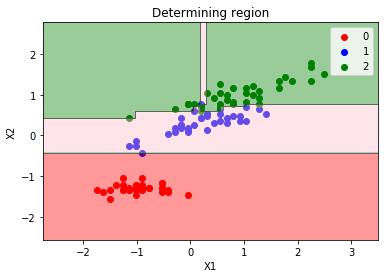

In [838]:
test.plot_decision_area_3class(X_train,y_train)

# 【問題8】決定木の利用場面

決定木はどうやって分類しているかがわかりやすく、説明力があるのでお客さんに見せるには良い。

特徴量のスケールを合わせなくても良い。

一つの線でターゲットを分けられないような分類問題があれば、決定木は有効そう。決定木はいくらでも分割が可能なので。

デメリットは、並列計算ができない（学習、推定）ので、計算コストは高くなる。

学習データへの過剰適合が問題になる。適切な深さの選択が重要。

